### 1. Data Loader: MNIST

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Subset, random_split, DataLoader

In [2]:
transform = transforms.ToTensor()

# Charger le dataset complet
dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# On garde seulement 30 % des données
total_size = len(dataset)
subset_size = int(0.3 * total_size)

# Sélection aléatoire de 30 % des indices
subset_indices = torch.randperm(total_size)[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

print(f"Taille du dataset réduit : {len(subset_dataset)}")

# Taille totale du subset (30 %)
subset_size = len(subset_dataset)

# Définir les proportions pour train, val, et test
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculer les tailles pour chaque ensemble
train_size = int(train_ratio * subset_size)
val_size = int(val_ratio * subset_size)
test_size = subset_size - train_size - val_size  # Reste pour éviter des erreurs d'arrondi


# Répartir le dataset réduit
train_dataset, val_dataset, test_dataset = random_split(
    subset_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(41)  # Pour un split reproductible
)

# Créer des DataLoaders pour chaque ensemble
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Taille du dataset réduit : 18000


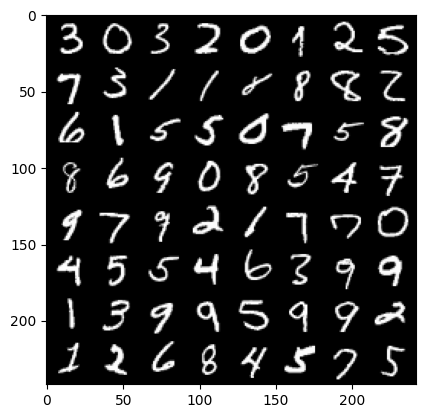

3 0 3 2 0 1 2 5 7 3 1 1 8 8 8 2 6 1 5 5 0 7 5 8 8 6 9 0 8 5 4 7 9 7 9 2 1 7 7 0 4 5 5 4 6 3 9 9 1 3 9 9 5 9 9 2 1 2 6 8 4 5 7 5


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def Myimshow(img):
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) --> (H, W, C)
    plt.show()

# get some training images randomly
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
Myimshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [4]:
# check if CUDA is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


### 2.1. Sauron

In [5]:
import random


# Classe pour le pruning Sauron
class SauronPruning:
    def __init__(self, mu=0.05, lambda_reg=0.5, tau_max=0.2, p = 3, k=10):
        self.mu = mu  # % of pruned filters for C3
        self.lambda_reg = lambda_reg  # from regularization term
        self.tau_max = tau_max  # maximum threshold
        self.p = p  # patience
        self.k = k  # number of steps to increase threshold before reachinf tau_max

    def fill_regularization_term(self, feature_maps):
        """
        Compute regularization term component of a single specific layer, to be added to each other layer in the forward function
        :param feature_maps: feature maps of the convolution layer
        :return: regularization term contribution from the layer
        """
        n_maps = feature_maps.size(1)
        regularization = 0
        
        t = random.randint(0, n_maps-1)
        for r in range(n_maps):
            dist = torch.norm(feature_maps[:, t] - feature_maps[:, r])
            regularization += dist
            
        return self.lambda_reg * regularization / n_maps
    
    
    def fill_delta_prune(self, feature_maps):
        """
        Fill delta_prune, distances between each feature of the layer and a randomly chosen feature of this layer, for each feature of a specific layer
        :param feature_maps: Features maps of the specific layer
        :return: (list) delta_prune
        """
        n_maps = feature_maps.size(1)
        pi = random.randint(0, n_maps-1)  # Randomly chosen feature index
        delta_prune_l = np.zeros(n_maps) # List of distances between each feature of the feature maps and the random feature pi
        
        for r in range(n_maps):
            if r != pi:
                delta_prune_l[r] = torch.norm(feature_maps[:, pi] - feature_maps[:, r])
        if max(delta_prune_l) == 0:
            return delta_prune_l
        return delta_prune_l / max(delta_prune_l)
                

    def elimination(self, convs, delta_prune, prev_pruned_ratio, thresholds):
        """
        Eliminate each redundant feature
        :param convs: Convolution layers
        :param delta_prune: Matrix of the distance between a randomly chosen feature and each feature of each layer
        :param thresholds: List of thresholds of each layer
        :return: Pruned filter ratio
        """
        
        L = len(convs)
        pruned_ratio = 0
        
        for l, layer in enumerate(convs):  # For each layer
            
            weights = layer.weight.data
            num_filters = weights.shape[0]

            for j in range(num_filters):  # For each filter
                if delta_prune[l][j] < thresholds[l]:  # Inside threshold -> Elimination
                    if delta_prune[l][j] != 0:  # Feature need to be not the random chosen feature
                        layer.weight.data[j] = 0  # Elimination
                        pruned_ratio += 1 / (L * num_filters)

        return pruned_ratio
    
    
    def threshold_actualization(self, convs, thresholds, tau_historic, training_loss, validation_loss):
        """
        Increase threshold when the conditions are satisfied
        :param convs: Concolution layers
        :param thresholds: List of thresholds of each layers
        :param tau_historic: List of steps number without increasing thresholds of each layers
        :param training_loss: List of size number of steps
        :param validation_loss: List of size number of steps
        :return: New historic of threshold actualization
        """
        for l, layer in enumerate(convs):
                        
            if len(training_loss) > 1:
                C1 = abs(training_loss[-1] - training_loss[-2]) < training_loss[-1]*0.1  # Training loss is converging
                C2 = validation_loss[-1] - validation_loss[-2] < 0  # Validation loss is not improving
            else:
                C1, C2 = True, True
            C3 = prev_pruned_ratio < self.mu  # Less than mu % filters pruned during last step
            C4 = tau_historic[l] > self.p  # Threshold unchanged since at least p steps
            
            # If conditions satisfied
            if (C1 and C2 and C3 and C4 and thresholds[l] < self.tau_max):
                # Threshold increasing
                thresholds[l] += self.tau_max / self.k
                tau_historic[l] = 0
            else:
                # Hisotric increasing
                tau_historic[l] += 1
                
        return tau_historic          

### 2.2. Define a Convolutional Neural Network (CNN)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Convolution: 1->32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Convolution: 32->64 channels
        self.convs = [self.conv1, self.conv2]
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fully connected layer: 64*7*7 -> 128
        self.fc2 = nn.Linear(128, 10)  # Fully connected layer: 128 -> 10 (classes)
        
        self.relu = nn.ReLU()
        
        self.regularization_term = 0
        self.delta_prune = []
        self.thresholds = np.zeros(len(self.convs))
        self.sauron_pruner = SauronPruning()

    def forward(self, x):
        
        self.delta_prune = []
        net.regularization_term = 0

        for i in range(len(self.convs)):
            
            x = self.pool(self.relu(self.convs[i](x)))  # CNN
            
            # Regularization term and distances for pruning computation
            self.regularization_term += self.sauron_pruner.fill_regularization_term(x) / len(self.convs)
            delta_prune_l = self.sauron_pruner.fill_delta_prune(x)
            self.delta_prune.append(delta_prune_l)
        
        # CNN linear fully connected layers
        x = x.view(-1, int(self.fc1.in_features))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

net = Net().to(device)

In [7]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### 3. Define a loss function and optimizer


In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

### 4. Train the network


In [9]:
import time
from datetime import timedelta
if torch.cuda.is_available():
  torch.cuda.synchronize()
start_epoch = time.time()

#=== train ==================

n = 20  # number of inputs in each step
epochs = 3
train_losses = []
val_losses = []
tau_historic = np.ones(len(net.convs)) * net.sauron_pruner.p
pruned_ratio = []
val_accuracies = []
thresholds_plot = []


for epoch in range(epochs):
    running_loss = 0.0
    running_pruned_ratio = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss += net.regularization_term 
        loss.backward()
        optimizer.step()
        prev_pruned_ratio = 0
        if len(pruned_ratio) > 0:
            prev_pruned_ratio = pruned_ratio[-1]
        pruned_ratio_i = net.sauron_pruner.elimination(net.convs, net.delta_prune, prev_pruned_ratio, net.thresholds)
        #pruned_ratio_i = 0
        running_pruned_ratio += pruned_ratio_i
        running_loss += loss.item()
        
        if i % n == n-1:  # steps
            
            # === Validation ===
            
            net.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels) 
                    loss += net.regularization_term 

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            # === Statistics ===
            
            train_losses.append(running_loss)
            pruned_ratio.append(running_pruned_ratio / n)
            thresholds_plot.append(net.thresholds.copy())
            print(f'[Epoch {epoch + 1}, Step {i + 1}] train loss: {running_loss:.3f}, validation loss: {val_loss:.3f}, pruned ratio: {running_pruned_ratio:.3f}, thresholds: {net.thresholds}')
            running_loss = 0.0
            running_pruned_ratio = 0.0
            
            # === Threshold actualization ===
            
            tau_historic = net.sauron_pruner.threshold_actualization(net.convs, net.thresholds, tau_historic, train_losses, val_losses)
            
#============================

if torch.cuda.is_available():
  torch.cuda.synchronize()
end_epoch = time.time()
elapsed = end_epoch - start_epoch
print(f'Training time: {str(timedelta(seconds=elapsed))}')

[Epoch 1, Step 20] train loss: 151.186, validation loss: 198.533, pruned ratio: 0.000, thresholds: [0. 0.]
[Epoch 1, Step 40] train loss: 140.971, validation loss: 182.995, pruned ratio: 0.000, thresholds: [0. 0.]
[Epoch 1, Step 60] train loss: 126.034, validation loss: 174.310, pruned ratio: 0.125, thresholds: [0.03 0.03]
[Epoch 1, Step 80] train loss: 122.522, validation loss: 172.796, pruned ratio: 0.000, thresholds: [0.03 0.03]
[Epoch 1, Step 100] train loss: 117.456, validation loss: 179.312, pruned ratio: 0.039, thresholds: [0.03 0.03]
[Epoch 1, Step 120] train loss: 115.993, validation loss: 158.317, pruned ratio: 0.023, thresholds: [0.03 0.03]
[Epoch 1, Step 140] train loss: 118.680, validation loss: 158.412, pruned ratio: 0.008, thresholds: [0.03 0.03]
[Epoch 1, Step 160] train loss: 105.259, validation loss: 151.438, pruned ratio: 0.047, thresholds: [0.03 0.03]
[Epoch 1, Step 180] train loss: 104.063, validation loss: 151.945, pruned ratio: 0.641, thresholds: [0.03 0.03]
[Epo

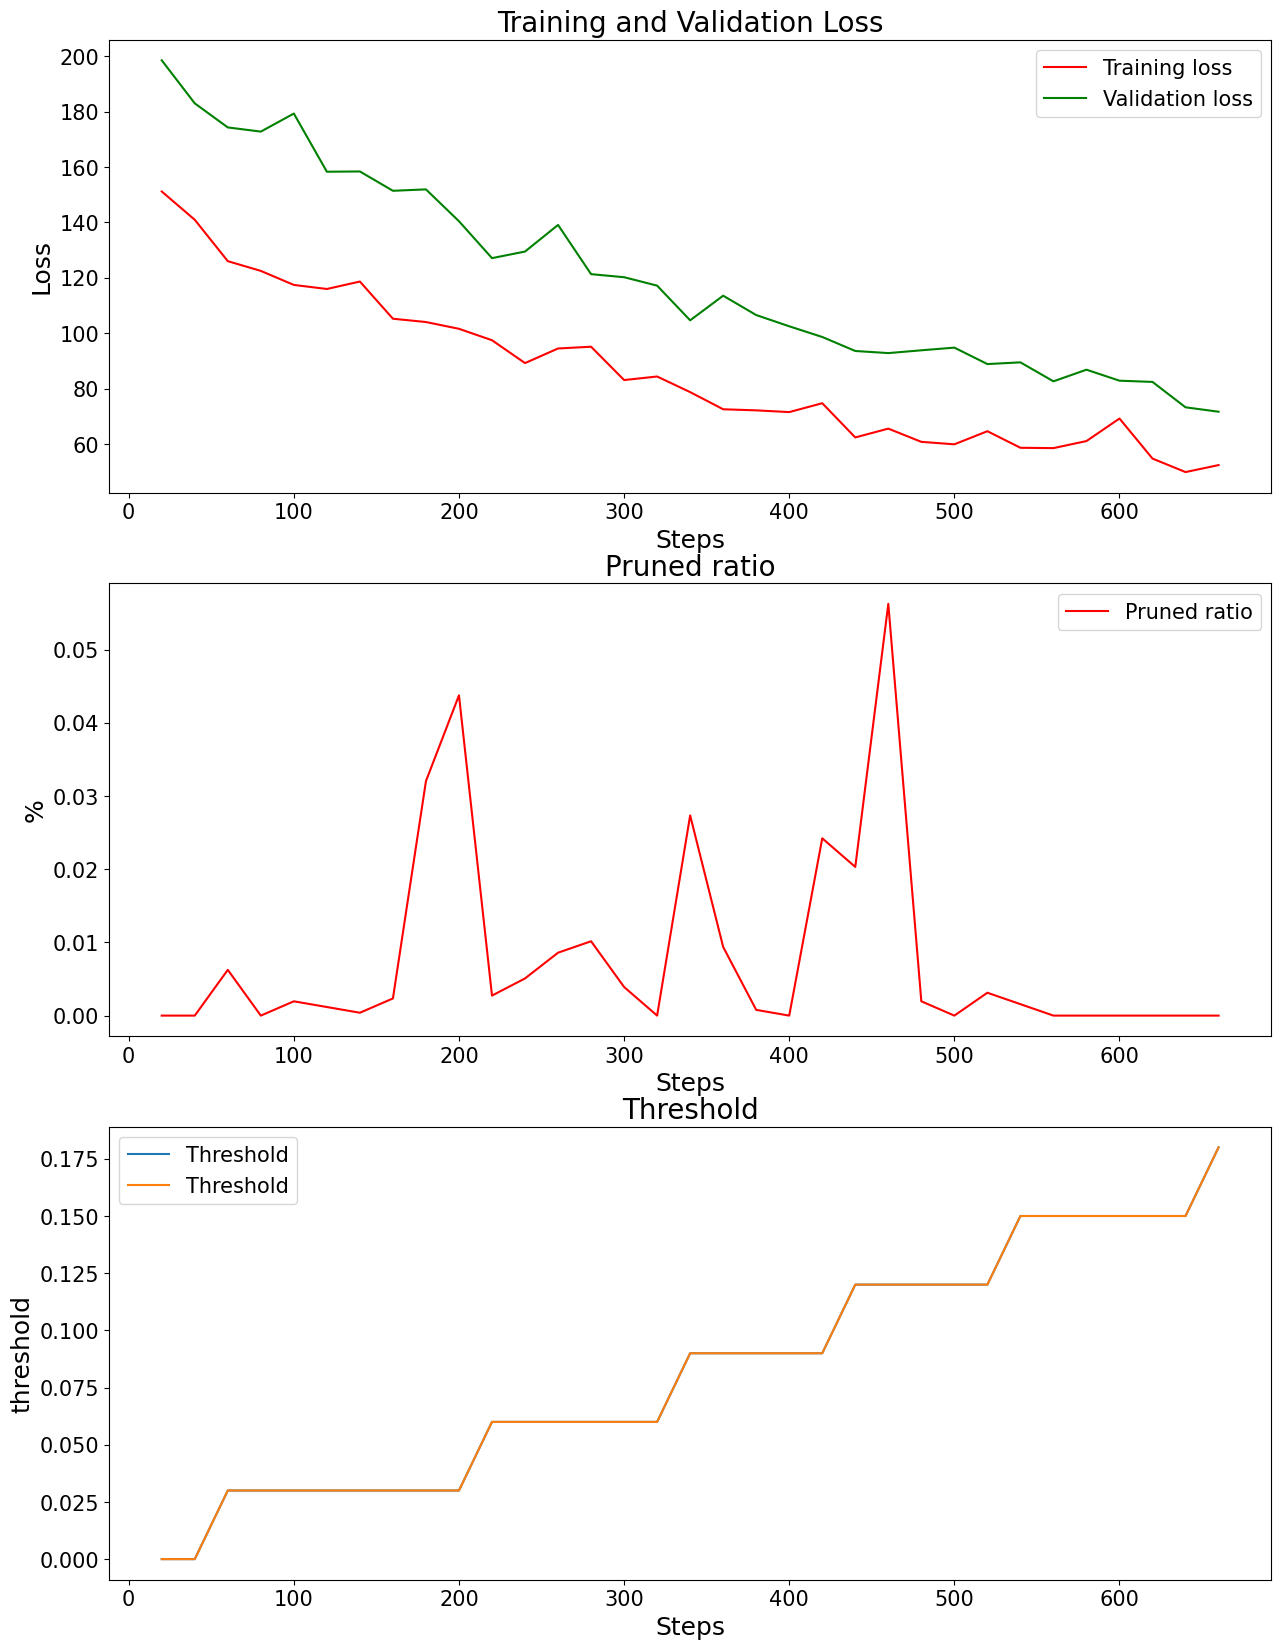

In [10]:
# plot the loss curve
x = [(i+1) * n for i in range(len(train_losses))]

plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20, 
    'axes.labelsize': 18,
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15,
    'legend.fontsize': 15 
})

fig, axes = plt.subplots(3, 1, figsize=(15, 20))
axes[0].set_title('Training and Validation Loss')
axes[0].plot(x, train_losses, label='Training loss', color='red')
axes[0].plot(x, val_losses, label='Validation loss', color='green')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].legend()


axes[1].set_title('Pruned ratio')
axes[1].plot(x, pruned_ratio, label='Pruned ratio', color='red')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('%')
axes[1].legend()

axes[2].set_title('Threshold')
for i in range(len(net.convs)):
    axes[2].plot(x, np.array(thresholds_plot).T[i], label='Threshold')
axes[2].set_xlabel('Steps')
axes[2].set_ylabel('threshold')
axes[2].legend()

plt.savefig('plot.png')
plt.show()


### 5. Test the network on the test data


In [11]:
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 1800 test images: 34 %
